# Signal IC Analysis Template

Run this notebook with `jupyter nbconvert --execute` to evaluate any model signal against baseline.

Examples:

```bash
MODEL_KEY=ridge_long jupyter nbconvert --to notebook --execute \
  notebooks/signal_ic_analysis_template.ipynb \
  --output ridge_long_ic_report.ipynb --output-dir notebooks/reports

MODEL_NAME=Custom MODEL_SIGNAL_DIR=data/processed/index_russell_huber_signal \
jupyter nbconvert --to notebook --execute notebooks/signal_ic_analysis_template.ipynb \
  --output custom_ic_report.ipynb --output-dir notebooks/reports
```


In [1]:
# Default parameters (can be overridden by environment variables in the next cell)
model_name = 'Ridge Long'
model_signal_dir = 'data/processed/index_russell_ridge_long_signal'
baseline_signal_dir = 'data/processed/futures_only_signal'

# Leave empty to use full universe from adr_info.csv excluding Australia/Japan
eligible_tickers = []

entry_times = ['13:00', '13:30', '14:00', '14:30', '15:00', '15:30']
main_time = '14:30'
min_obs = 30
filter_to_model_active_dates = True

report_dir = 'data/processed/reports/signal_ic'


In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Resolve project paths robustly for nbconvert invocation from repo root or notebooks/
def resolve_data_dir():
    candidates = [Path('data'), Path('../data')]
    for c in candidates:
        if (c / 'raw' / 'adr_info.csv').exists():
            return c
    raise FileNotFoundError('Could not resolve data directory. Tried: data/, ../data/')

# MODEL_KEY shortcuts for common experiment outputs
MODEL_KEY_MAP = {
    'ridge_long': ('Ridge Long', 'data/processed/index_russell_ridge_long_signal'),
    'ridge': ('Ridge', 'data/processed/index_russell_ridge_signal'),
    'pcr': ('PCR', 'data/processed/index_russell_pcr_signal'),
    'elasticnet': ('ElasticNet', 'data/processed/index_russell_elasticnet_signal'),
    'rrr': ('RRR', 'data/processed/index_russell_rrr_signal'),
    'random_forest': ('RandomForest', 'data/processed/index_russell_random_forest_signal'),
    'huber': ('Huber', 'data/processed/index_russell_huber_signal'),
    'lasso': ('Lasso', 'data/processed/index_russell_lasso_signal'),
    'futures_only': ('Futures Only', 'data/processed/futures_only_signal'),
}

model_key = os.getenv('MODEL_KEY', '').strip().lower()
env_model_signal_dir = os.getenv('MODEL_SIGNAL_DIR', '').strip()
env_model_name = os.getenv('MODEL_NAME', '').strip()

if env_model_signal_dir:
    model_signal_dir = env_model_signal_dir
    if env_model_name:
        model_name = env_model_name
elif model_key:
    if model_key not in MODEL_KEY_MAP:
        raise ValueError(f'Unknown MODEL_KEY={model_key}. Valid keys: {sorted(MODEL_KEY_MAP)}')
    model_name, model_signal_dir = MODEL_KEY_MAP[model_key]

DATA_DIR = resolve_data_dir()
PROJECT_ROOT = DATA_DIR.parent
ADR_CLOSE_FILE = DATA_DIR / 'raw' / 'adrs' / 'adr_PX_LAST_adjust_none.csv'
ETF_CLOSE_FILE = DATA_DIR / 'raw' / 'etfs' / 'market' / 'market_etf_PX_LAST_adjust_none.csv'

model_signal_dir = Path(model_signal_dir)
baseline_signal_dir = Path(baseline_signal_dir)
report_dir = Path(report_dir)

if not model_signal_dir.is_absolute():
    model_signal_dir = PROJECT_ROOT / model_signal_dir
if not baseline_signal_dir.is_absolute():
    baseline_signal_dir = PROJECT_ROOT / baseline_signal_dir
if not report_dir.is_absolute():
    report_dir = PROJECT_ROOT / report_dir

report_dir.mkdir(parents=True, exist_ok=True)

model_slug = model_name.lower().replace(' ', '_').replace('-', '_')
print(f'Model: {model_name}')
print(f'PROJECT_ROOT: {PROJECT_ROOT}')
print(f'DATA_DIR: {DATA_DIR}')
print(f'Model signal dir: {model_signal_dir}')
print(f'Baseline signal dir: {baseline_signal_dir}')
print(f'Report dir: {report_dir}')


Model: PLS Regression
PROJECT_ROOT: ..
DATA_DIR: ../data
Model signal dir: ../data/processed/index_russell_pls_signal
Baseline signal dir: ../data/processed/futures_only_signal
Report dir: ../data/processed/reports/signal_ic


In [3]:
# Universe + hedge inputs
EXCLUDED_COUNTRIES = {'AUSTRALIA', 'JAPAN'}

adr_info = pd.read_csv(DATA_DIR / 'raw' / 'adr_info.csv')
adr_info['ticker'] = adr_info['adr'].str.replace(' US Equity', '', regex=False)
adr_info = adr_info[~adr_info['country'].isin(EXCLUDED_COUNTRIES)].copy()
ticker_to_etf = dict(zip(adr_info['ticker'], adr_info['market_etf_hedge']))

all_tickers = sorted(adr_info['ticker'].tolist())
if eligible_tickers:
    tickers = sorted([t for t in all_tickers if t in set(eligible_tickers)])
else:
    tickers = all_tickers

hedge_ratios = pd.read_csv(DATA_DIR / 'processed' / 'market_etf_hedge_ratios.csv', index_col=0, parse_dates=True)
close_df = pd.read_csv(ADR_CLOSE_FILE, index_col=0, parse_dates=True)
etf_close_df = pd.read_csv(ETF_CLOSE_FILE, index_col=0, parse_dates=True)

print(f'Tickers in analysis universe: {len(tickers)}')
print(f'Hedge ratios shape: {hedge_ratios.shape}')


Tickers in analysis universe: 45
Hedge ratios shape: (1872, 54)


In [4]:
def load_nbbo_mid(path, col_name):
    df = pd.read_parquet(path, columns=['nbbo_bid', 'nbbo_ask'])
    out = pd.DataFrame(index=df.index)
    out[col_name] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    out['date'] = out.index.tz_localize(None).normalize()
    return out


def extract_prices_at_times(mid_df, times, value_col):
    all_dates = sorted(mid_df['date'].unique())
    res = pd.DataFrame(index=pd.DatetimeIndex(all_dates))
    for t in times:
        s = mid_df.between_time(t, t)[value_col]
        if len(s) == 0:
            res[t] = np.nan
            continue
        idx = s.index.tz_localize(None).normalize()
        ser = pd.Series(s.values, index=idx).groupby(level=0).first()
        res[t] = ser.reindex(res.index)
    return res


def load_signal_at_times(signal_dir, tickers, entry_times):
    signals = {}
    for ticker in tqdm(tickers):
        path = signal_dir / f'ticker={ticker}' / 'data.parquet'
        if not path.exists():
            continue
        df = pd.read_parquet(path)
        for entry_time in entry_times:
            h, m = map(int, entry_time.split(':'))
            mask = (df.index.hour == h) & (df.index.minute == m)
            sig_at_time = df.loc[mask, 'signal']
            if len(sig_at_time) == 0:
                continue
            idx = sig_at_time.index.tz_localize(None).normalize()
            ser = pd.Series(sig_at_time.values, index=idx).groupby(level=0).first()
            signals[(ticker, entry_time)] = ser
    return signals


def compute_ic_filtered(signals, hedged_returns, entry_times, tickers, date_filter=None, min_obs=30):
    per_ticker_ic = pd.DataFrame(index=tickers, columns=entry_times, dtype=float)
    per_ticker_n = pd.DataFrame(index=tickers, columns=entry_times, dtype=float)
    pooled_data = {t: {'signal': [], 'actual': []} for t in entry_times}
    cs_ic_by_date = {t: {} for t in entry_times}

    for ticker in tickers:
        for entry_time in entry_times:
            key = (ticker, entry_time)
            if key not in signals or key not in hedged_returns:
                continue

            sig = signals[key]
            ret = hedged_returns[key]
            common = sig.index.intersection(ret.index)

            if date_filter is not None and key in date_filter:
                common = common.intersection(pd.Index(list(date_filter[key])))

            if len(common) < min_obs:
                continue

            s = sig.loc[common].values
            r = ret.loc[common].values
            valid = ~(np.isnan(s) | np.isnan(r) | np.isinf(s) | np.isinf(r))
            s, r = s[valid], r[valid]
            common_valid = np.array(common)[valid]

            if len(s) < min_obs:
                continue

            ic = np.corrcoef(s, r)[0, 1] if np.std(s) > 0 and np.std(r) > 0 else np.nan
            per_ticker_ic.loc[ticker, entry_time] = ic
            per_ticker_n.loc[ticker, entry_time] = len(s)

            pooled_data[entry_time]['signal'].extend(s)
            pooled_data[entry_time]['actual'].extend(r)

            for d, sv, rv in zip(common_valid, s, r):
                d = pd.Timestamp(d)
                if d not in cs_ic_by_date[entry_time]:
                    cs_ic_by_date[entry_time][d] = {'s': [], 'r': []}
                cs_ic_by_date[entry_time][d]['s'].append(sv)
                cs_ic_by_date[entry_time][d]['r'].append(rv)

    pooled_ic = {}
    pooled_n = {}
    for t in entry_times:
        s = np.array(pooled_data[t]['signal'])
        r = np.array(pooled_data[t]['actual'])
        pooled_n[t] = len(s)
        pooled_ic[t] = np.corrcoef(s, r)[0, 1] if len(s) >= min_obs and np.std(s) > 0 and np.std(r) > 0 else np.nan

    cs_mean, cs_se, cs_days = {}, {}, {}
    for t in entry_times:
        day_ics = []
        for d, vals in cs_ic_by_date[t].items():
            s = np.array(vals['s'])
            r = np.array(vals['r'])
            if len(s) < 2 or np.std(s) == 0 or np.std(r) == 0:
                continue
            day_ics.append(np.corrcoef(s, r)[0, 1])
        if len(day_ics) > 0:
            cs_mean[t] = float(np.mean(day_ics))
            cs_se[t] = float(np.std(day_ics, ddof=1) / np.sqrt(len(day_ics))) if len(day_ics) > 1 else np.nan
            cs_days[t] = len(day_ics)
        else:
            cs_mean[t], cs_se[t], cs_days[t] = np.nan, np.nan, 0

    return (
        per_ticker_ic,
        per_ticker_n,
        pd.Series(pooled_ic),
        pd.Series(pooled_n),
        pd.Series(cs_mean),
        pd.Series(cs_se),
        pd.Series(cs_days),
    )


In [5]:
# Build hedged returns from entry mid to daily close
adr_prices = {}
for ticker in tqdm(tickers, desc='ADR NBBO'):
    path = DATA_DIR / 'raw' / 'adrs' / 'bbo-1m' / 'nbbo' / f'ticker={ticker}' / 'data.parquet'
    if not path.exists():
        continue
    mid = load_nbbo_mid(path, 'mid')
    adr_prices[ticker] = extract_prices_at_times(mid, entry_times, 'mid')

etf_prices = {}
for etf in sorted(set(ticker_to_etf[t] for t in tickers if t in ticker_to_etf)):
    path = DATA_DIR / 'raw' / 'etfs' / 'market' / 'bbo-1m' / 'nbbo' / f'ticker={etf}' / 'data.parquet'
    if not path.exists():
        continue
    mid = load_nbbo_mid(path, 'etf_mid')
    etf_prices[etf] = extract_prices_at_times(mid, entry_times, 'etf_mid')

hedged_returns = {}
for ticker in tickers:
    if ticker not in adr_prices:
        continue
    etf = ticker_to_etf.get(ticker)
    if etf not in etf_prices:
        continue
    if ticker not in hedge_ratios.columns or ticker not in close_df.columns or etf not in etf_close_df.columns:
        continue

    adr_px = adr_prices[ticker]
    etf_px = etf_prices[etf]
    adr_close = close_df[ticker].dropna()
    etf_close = etf_close_df[etf].dropna()
    hr = hedge_ratios[ticker].dropna()

    common_dates = adr_px.index.intersection(etf_px.index).intersection(adr_close.index).intersection(etf_close.index)
    if len(common_dates) == 0:
        continue

    for entry_time in entry_times:
        adr_entry = adr_px.loc[common_dates, entry_time]
        etf_entry = etf_px.loc[common_dates, entry_time]
        valid = adr_entry.notna() & etf_entry.notna()
        d = common_dates[valid.values]
        if len(d) == 0:
            continue

        ae = adr_entry.loc[d].astype(float)
        ee = etf_entry.loc[d].astype(float)
        ac = adr_close.reindex(d).astype(float)
        ec = etf_close.reindex(d).astype(float)
        hr_aligned = hr.reindex(d).astype(float)

        adr_ret = (ac - ae) / ae
        etf_ret = (ec - ee) / ee
        hedged = (adr_ret - hr_aligned * etf_ret).replace([np.inf, -np.inf], np.nan).dropna()
        if len(hedged) == 0:
            continue

        hedged_returns[(ticker, entry_time)] = pd.Series(hedged.values, index=hedged.index, name=ticker)

print(f'Hedged return pairs: {len(hedged_returns)}')


ADR NBBO:   0%|          | 0/45 [00:00<?, ?it/s]

Hedged return pairs: 270


In [6]:
print(f'Loading model signals: {model_signal_dir}')
model_signals = load_signal_at_times(model_signal_dir, tickers, entry_times)
print(f'Model signal pairs: {len(model_signals)}')

print(f'Loading baseline signals: {baseline_signal_dir}')
baseline_signals = load_signal_at_times(baseline_signal_dir, tickers, entry_times)
print(f'Baseline signal pairs: {len(baseline_signals)}')


Loading model signals: ../data/processed/index_russell_pls_signal


  0%|          | 0/45 [00:00<?, ?it/s]

Model signal pairs: 234
Loading baseline signals: ../data/processed/futures_only_signal


  0%|          | 0/45 [00:00<?, ?it/s]

Baseline signal pairs: 270


In [7]:
date_filter = None
if filter_to_model_active_dates:
    model_active_dates = {}
    for key in sorted(set(model_signals.keys()).intersection(baseline_signals.keys())):
        m = model_signals[key]
        b = baseline_signals[key]
        common = m.index.intersection(b.index)
        differs = m.loc[common].values != b.loc[common].values
        active = set(common[differs])
        if len(active) > 0:
            model_active_dates[key] = active
    date_filter = model_active_dates

    total_pairs = len(model_active_dates)
    total_obs = sum(len(v) for v in model_active_dates.values())
    print(f'Active pairs: {total_pairs}, active observations: {total_obs}')
else:
    print('Using all overlapping dates (no model-active filter).')


Active pairs: 234, active observations: 22176


In [8]:
model_per_ticker, model_per_n, model_pooled, model_pooled_n, model_cs, model_cs_se, model_cs_days =     compute_ic_filtered(model_signals, hedged_returns, entry_times, tickers, date_filter=date_filter, min_obs=min_obs)

base_per_ticker, base_per_n, base_pooled, base_pooled_n, base_cs, base_cs_se, base_cs_days =     compute_ic_filtered(baseline_signals, hedged_returns, entry_times, tickers, date_filter=date_filter, min_obs=min_obs)

pooled = pd.DataFrame({
    model_name: model_pooled,
    'Baseline': base_pooled,
    'Improvement': model_pooled - base_pooled,
    'N obs': model_pooled_n,
})
pooled.index.name = 'Entry Time'

cross = pd.DataFrame({
    f'{model_name} IC': model_cs,
    f'{model_name} SE': model_cs_se,
    'Baseline IC': base_cs,
    'Baseline SE': base_cs_se,
    'Improvement': model_cs - base_cs,
    'N days': model_cs_days,
})
cross.index.name = 'Entry Time'

per_ticker = pd.DataFrame({
    f'{model_name} IC': model_per_ticker[main_time],
    'Baseline IC': base_per_ticker[main_time],
    'Improvement': model_per_ticker[main_time].astype(float) - base_per_ticker[main_time].astype(float),
    'N obs': model_per_n[main_time],
}).dropna().sort_values('Improvement', ascending=False)

mean_by_time = pd.DataFrame({
    model_name: model_per_ticker.astype(float).mean(),
    'Baseline': base_per_ticker.astype(float).mean(),
})
mean_by_time['Improvement'] = mean_by_time[model_name] - mean_by_time['Baseline']
mean_by_time.index.name = 'Entry Time'

print('Pooled IC')
display(pooled.round(4))
print('Cross-sectional IC')
display(cross.round(4))
print(f'Per-ticker IC at {main_time}')
display(per_ticker.round(4))


Pooled IC


,PLS Regression,Baseline,Improvement,N obs
Entry Time,,,,
13:00,0.0254,0.0171,0.0084,3688
13:30,0.0209,0.0176,0.0034,3688
14:00,0.0284,0.0164,0.0120,3688
14:30,0.0310,0.0137,0.0173,3688
15:00,0.0310,0.0151,0.0158,3688
15:30,0.0209,0.0104,0.0104,3688


Cross-sectional IC


,PLS Regression IC,PLS Regression SE,Baseline IC,Baseline SE,Improvement,N days
Entry Time,,,,,,
13:00,0.0164,0.0192,0.0669,0.0113,-0.0505,96
13:30,0.0300,0.0196,0.0815,0.0113,-0.0515,96
14:00,0.0450,0.0201,0.0924,0.0111,-0.0474,96
14:30,0.0481,0.0205,0.0953,0.0114,-0.0472,96
15:00,0.0432,0.0211,0.0977,0.0111,-0.0545,96
15:30,0.0340,0.0184,0.0852,0.0109,-0.0513,96


Per-ticker IC at 14:30


,PLS Regression IC,Baseline IC,Improvement,N obs
BCS,0.3130,0.0543,0.2587,94.0
AEG,0.1646,0.0073,0.1573,96.0
NVO,0.0246,-0.1215,0.1461,96.0
RELX,0.1990,0.0658,0.1332,94.0
TS,-0.0357,-0.1616,0.1259,96.0
NOK,-0.0361,-0.1521,0.1160,95.0
NGG,0.1205,0.0235,0.0970,94.0
VOD,0.0590,-0.0315,0.0905,94.0
DEO,0.0829,-0.0075,0.0904,94.0
RIO,0.0381,-0.0508,0.0889,94.0


In [9]:
# Save report artifacts
pooled_path = report_dir / f'{model_slug}_pooled_ic.csv'
cross_path = report_dir / f'{model_slug}_cross_sectional_ic.csv'
per_ticker_path = report_dir / f'{model_slug}_per_ticker_{main_time.replace(":","")}.csv'
mean_path = report_dir / f'{model_slug}_mean_per_ticker_by_time.csv'

pooled.to_csv(pooled_path)
cross.to_csv(cross_path)
per_ticker.to_csv(per_ticker_path)
mean_by_time.to_csv(mean_path)

print('Saved:')
print(pooled_path)
print(cross_path)
print(per_ticker_path)
print(mean_path)


Saved:
../data/processed/reports/signal_ic/pls_regression_pooled_ic.csv
../data/processed/reports/signal_ic/pls_regression_cross_sectional_ic.csv
../data/processed/reports/signal_ic/pls_regression_per_ticker_1430.csv
../data/processed/reports/signal_ic/pls_regression_mean_per_ticker_by_time.csv


Monthly IC at main time (14:30)


series,Baseline,PLS Regression,Improvement
month,,,
2018-09-01,0.0925,NaN,NaN
2018-10-01,0.1364,NaN,NaN
2018-11-01,0.1830,NaN,NaN
2018-12-01,-0.0801,NaN,NaN
2019-01-01,0.1703,NaN,NaN
...,...,...,...
2025-10-01,0.0235,0.0528,0.0293
2025-11-01,-0.0120,0.0014,0.0134
2025-12-01,-0.0125,0.0376,0.0501


Saved figure: ../data/processed/reports/signal_ic/pls_regression_monthly_ic.png


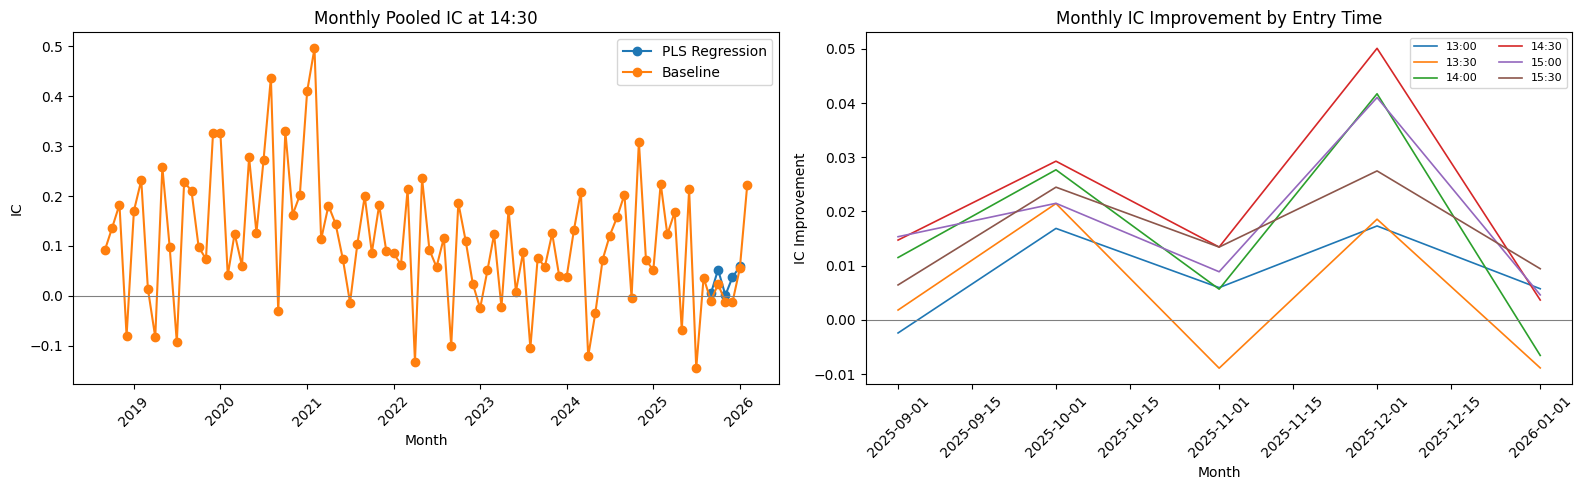

Saved: ../data/processed/reports/signal_ic/pls_regression_monthly_ic_1430.csv
Saved: ../data/processed/reports/signal_ic/pls_regression_monthly_ic_full.csv


In [10]:
# Time-varying IC analysis (monthly pooled IC)
def compute_monthly_pooled_ic(signals, hedged_returns, entry_times, tickers, date_filter=None, min_obs=20):
    rows = []
    for entry_time in entry_times:
        month_buckets = {}
        for ticker in tickers:
            key = (ticker, entry_time)
            if key not in signals or key not in hedged_returns:
                continue

            sig = signals[key]
            ret = hedged_returns[key]
            common = sig.index.intersection(ret.index)
            if date_filter is not None and key in date_filter:
                common = common.intersection(pd.Index(list(date_filter[key])))
            if len(common) == 0:
                continue

            s = sig.loc[common].astype(float)
            r = ret.loc[common].astype(float)
            valid = ~(s.isna() | r.isna() | np.isinf(s.values) | np.isinf(r.values))
            s = s[valid]
            r = r[valid]
            if len(s) == 0:
                continue

            months = s.index.to_period('M').astype(str)
            for sv, rv, m in zip(s.values, r.values, months):
                month_buckets.setdefault(m, {'s': [], 'r': []})
                month_buckets[m]['s'].append(float(sv))
                month_buckets[m]['r'].append(float(rv))

        for month, vals in month_buckets.items():
            s = np.array(vals['s'])
            r = np.array(vals['r'])
            n = len(s)
            ic = np.corrcoef(s, r)[0, 1] if n >= min_obs and np.std(s) > 0 and np.std(r) > 0 else np.nan
            rows.append({'month': month, 'entry_time': entry_time, 'ic': ic, 'n_obs': n})

    out = pd.DataFrame(rows, columns=['month', 'entry_time', 'ic', 'n_obs'])
    if len(out) == 0:
        return out
    out['month'] = pd.PeriodIndex(out['month'], freq='M').to_timestamp()
    return out.sort_values(['entry_time', 'month'])

model_monthly = compute_monthly_pooled_ic(
    model_signals, hedged_returns, entry_times, tickers, date_filter=date_filter, min_obs=min_obs
)
model_monthly['series'] = model_name

base_monthly = compute_monthly_pooled_ic(
    baseline_signals, hedged_returns, entry_times, tickers, date_filter=date_filter, min_obs=min_obs
)
base_monthly['series'] = 'Baseline'

monthly_ic = pd.concat([model_monthly, base_monthly], ignore_index=True)

if len(monthly_ic) == 0:
    main_monthly = pd.DataFrame(columns=[model_name, 'Baseline', 'Improvement'])
else:
    main_monthly = monthly_ic[monthly_ic['entry_time'] == main_time].pivot(index='month', columns='series', values='ic').sort_index()
    if model_name in main_monthly.columns and 'Baseline' in main_monthly.columns:
        main_monthly['Improvement'] = main_monthly[model_name] - main_monthly['Baseline']

print(f'Monthly IC at main time ({main_time})')
display(main_monthly.round(4))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Main-time monthly IC
ax = axes[0]
if len(main_monthly) > 0:
    if model_name in main_monthly.columns:
        ax.plot(main_monthly.index, main_monthly[model_name], label=model_name, marker='o', linewidth=1.5)
    if 'Baseline' in main_monthly.columns:
        ax.plot(main_monthly.index, main_monthly['Baseline'], label='Baseline', marker='o', linewidth=1.5)
ax.axhline(0, color='gray', linewidth=0.8)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title(f'Monthly Pooled IC at {main_time}')
ax.set_xlabel('Month')
ax.set_ylabel('IC')
ax.legend()

# Monthly improvement by entry time
ax = axes[1]
if len(model_monthly) > 0 and len(base_monthly) > 0:
    piv_model = model_monthly.pivot(index='month', columns='entry_time', values='ic')
    piv_base = base_monthly.pivot(index='month', columns='entry_time', values='ic')
    for et in entry_times:
        if et in piv_model.columns and et in piv_base.columns:
            imp = piv_model[et] - piv_base[et]
            ax.plot(imp.index, imp.values, label=et, linewidth=1.2)
ax.axhline(0, color='gray', linewidth=0.8)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('Monthly IC Improvement by Entry Time')
ax.set_xlabel('Month')
ax.set_ylabel('IC Improvement')
ax.legend(ncol=2, fontsize=8)

plt.tight_layout()
monthly_fig_path = report_dir / f'{model_slug}_monthly_ic.png'
plt.savefig(monthly_fig_path, dpi=150, bbox_inches='tight')
print(f'Saved figure: {monthly_fig_path}')
plt.show()

monthly_main_path = report_dir / f'{model_slug}_monthly_ic_{main_time.replace(":","")}.csv'
monthly_full_path = report_dir / f'{model_slug}_monthly_ic_full.csv'
main_monthly.to_csv(monthly_main_path)
monthly_ic.to_csv(monthly_full_path, index=False)
print(f'Saved: {monthly_main_path}')
print(f'Saved: {monthly_full_path}')


Saved figure: ../data/processed/reports/signal_ic/pls_regression_ic_summary.png


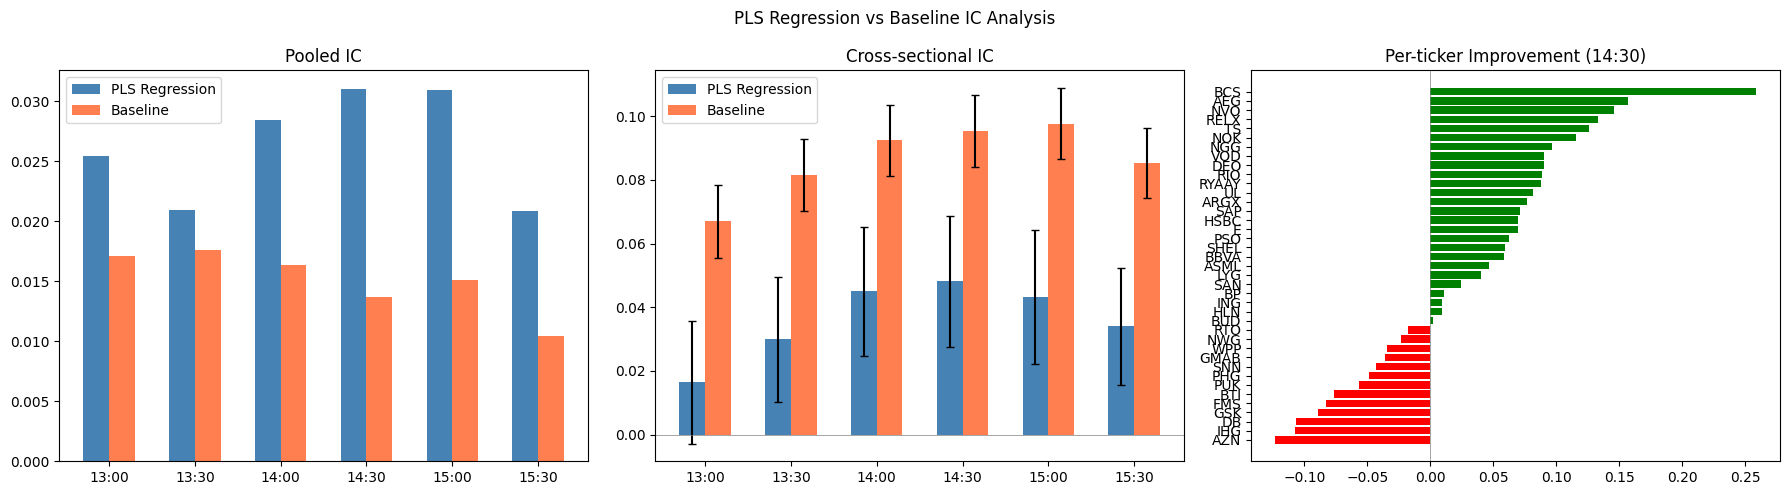

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x = range(len(entry_times))

axes[0].bar([i - 0.15 for i in x], model_pooled.values, 0.3, label=model_name, color='steelblue')
axes[0].bar([i + 0.15 for i in x], base_pooled.values, 0.3, label='Baseline', color='coral')
axes[0].set_xticks(list(x))
axes[0].set_xticklabels(entry_times)
axes[0].set_title('Pooled IC')
axes[0].axhline(0, color='gray', linewidth=0.5)
axes[0].legend()

axes[1].bar([i - 0.15 for i in x], model_cs.values, 0.3, label=model_name, color='steelblue', yerr=model_cs_se.values, capsize=3)
axes[1].bar([i + 0.15 for i in x], base_cs.values, 0.3, label='Baseline', color='coral', yerr=base_cs_se.values, capsize=3)
axes[1].set_xticks(list(x))
axes[1].set_xticklabels(entry_times)
axes[1].set_title('Cross-sectional IC')
axes[1].axhline(0, color='gray', linewidth=0.5)
axes[1].legend()

imp = per_ticker['Improvement'].sort_values()
colors = ['green' if v > 0 else 'red' for v in imp.values]
axes[2].barh(range(len(imp)), imp.values, color=colors)
axes[2].set_yticks(range(len(imp)))
axes[2].set_yticklabels(imp.index)
axes[2].set_title(f'Per-ticker Improvement ({main_time})')
axes[2].axvline(0, color='gray', linewidth=0.5)

plt.suptitle(f'{model_name} vs Baseline IC Analysis')
plt.tight_layout()

fig_path = report_dir / f'{model_slug}_ic_summary.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f'Saved figure: {fig_path}')
plt.show()
